# A convolutional neural network to discover gravitational waves buried in detector noise

Gravitational waves (GWs) are ripples in the spacetime fabric that are generated during some of the most extreme events that happen in the Universe, like the explosion of a supernova or the collision of black holes (BHs) and neutron stars. These waves travel through spacetime at the speed of light until they eventual reach the Earth. There are three sites on planet Earth where extremely sensitive detectors lie waiting for a GW to pass through them, reveling its passage: the two LIGO detector in Hanford and Livingston (USA) and the VIRGO detector near Pisa (Italy).

The detectors work like this (though I'm simplifying a lot!): a laser beam is reflected between two mirrors, which are suspended to isolate them from the ground movements. Knowing the distance between the mirrors and the speed of the laser beam (speed of light), one known how long it should take for the laser beam to do a round trip from a mirror to the next one and back to the first one. When a GW passes through the detector, its effect is that of slightly reducing and incresing - in an oscillatory behaviour - the distance between the mirrors. Thus, a GW can be detected when an oscillatory increase and decrease of the laser travel time between the mirrors is revealed.

To give an example of the incredible sensitivity that is needed to detect the passage of a GW, I'm quoting <a href="https://en.wikipedia.org/wiki/Gravitational_wave#Effects_of_passing">Wikipedia</a>: "... the waves given off by the cataclysmic final merger of GW150914 reached Earth after travelling over a billion light-years, as a ripple in spacetime that changed the length of a 4 km LIGO arm by a thousandth of the width of a proton, proportionally equivalent to changing the distance to the nearest star outside the Solar System by one hair's width ...".

Unfortunately, all detectors suffer from noise. In the case of GW detectors, being astonishingly sensitive, they continuously register noise that comes from various natural and human activities, like earthquakes, thunderstorms and even traffic on the nearby highway! For this reason, GWs passing through the detectors are completely buried inside the detector noise, and are totally unrecognisable by the human eye.

Fortunately, there exist a quite old technique called "<a href="https://en.wikipedia.org/wiki/Matched_filter">matched filter</a>" which allows one to detect the presence of a template signal (i.e. what we expect the GW to be like) in an unknown signal (i.e. the signal registered by the detector, that is dominated by noise). However, this technique requires first the computation and storage of hundreds of thousand of templates, and then the computation of the matched filter for all templates stored for all signal registered by the detector. Thus, it is extremely time consuming and computationally expensive.

For this reason, in the recent years much effort has been devoted to the development of neural networks to discover the presence of a GW signal inside the noise registered by the detector. This is thanks to the scalability of neural networks, their ability to generalise to previously unseen patterns and their speed once training has been completed.

This notebook is used to define, train and test a convolutional neural network that detects a gravitational wave (GW) signal buried in detector noise.

The training, validation and test data is generated in the <code>data_generator.ipynb</code> notebook.

In [1]:
from tqdm import tqdm

import datetime
import time 
import matplotlib.pyplot as plt
import os
import numpy as np
from random import seed
from random import random

import tensorflow as tf
import tensorflow.compat.v1 as tf1
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, ReLU, Softmax
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from tensorflow.keras.callbacks import Callback
import keras_tuner as kt

import pandas as pd
import seaborn as sns
plt.style.use("seaborn")

keras.backend.clear_session() # clearing the previous session

# Setting parallelisation settings for Tensorflow and Keras 
# Assume that the number of cores per socket in the machine is denoted as NUM_PARALLEL_EXEC_UNITS
# when NUM_PARALLEL_EXEC_UNITS=0 the system chooses appropriate settings 
# https://software.intel.com/content/www/us/en/develop/articles/tips-to-improve-performance-for-popular-deep-learning-frameworks-on-multi-core-cpus.html
# For my Intel i710750h:
# CPU(s):              12
# Thread(s) per core:  2
# Core(s) per socket:  6
# Socket(s):           1
#
# From https://stackoverflow.com/questions/41233635/meaning-of-inter-op-parallelism-threads-and-intra-op-parallelism-threads: 
#
# If you have an operation that can be parallelized internally, such as matrix multiplication (tf.matmul()) or a reduction (e.g. tf.reduce_sum()), 
# TensorFlow will execute it by scheduling tasks in a thread pool with intra_op_parallelism_threads threads. This configuration option therefore controls
# the maximum parallel speedup for a single operation. Note that if you run multiple operations in parallel, these operations will share this thread pool.
#
# If you have many operations that are independent in your TensorFlow graph—because there is no directed path between them in the dataflow graph—TensorFlow
# will attempt to run them concurrently, using a thread pool with inter_op_parallelism_threads threads. If those operations have a multithreaded implementation#
# they will (in most cases) share the same thread pool for intra-op parallelism.
#
# If you set allow_soft_placement as false and device as GPU but GPU cannot be found in your machine it raises error.
# If allow_soft_placement is true, an op will be placed on CPU if
# 1. there's no GPU implementation for the OP;
# or
# 2. no GPU devices are known or registered;
# or
# 3. need to co-locate with reftype input(s) which are from CPU.

NUM_PARALLEL_EXEC_UNITS = 12
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS,
                                  inter_op_parallelism_threads=2,
                                  allow_soft_placement=True,
                                  device_count = {'CPU': NUM_PARALLEL_EXEC_UNITS })

session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# Setting environment variables for OMP and KMP.
# See notebook data_generator.ipynb for more details.
# https://scc.ustc.edu.cn/zlsc/sugon/intel/compiler_c/main_cls/bldaps_cls/common/bldaps_env_vars1_comm.htm
os.environ["OMP_NUM_THREADS"] = "NUM_PARALLEL_EXEC_UNITS"
os.environ["KMP_BLOCKTIME"] = "30"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

datapath = r'C:\\Users\\solda\\Documents\\code\\ML\\mycnn_gw\\new'
thispath = r'C:\\Users\\solda\\Documents\\code\\ML\\mycnn_gw\\new\\GWCNN'
    
print("Tensorflow version: ",tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Tensorflow version:  2.4.1
Num GPUs Available:  1
Num CPUs Available:  1


Let's check that data files we read are the correct ones, and let's print some numbers to understand the size of the dataset we have to deal with.
Moreover, we define a function that is used to read the data compressed inside the <code>.tfrecord</code> files.

In [2]:
pathdata = os.path.join(datapath,'trvaldata')

f = np.fromfile(os.path.join(pathdata,'config.txt'),count=-1,sep=' ')

n_timesteps = int(f[0])
n_tot = int(f[1])
n_bbh = int(f[2])
n_noise = int(f[3])
n_chunks = int(f[4])

print("\n Number of timesteps for each sample: ", n_timesteps,". \n")
print("\n Number of samples in each data file: ", n_bbh, 'signals + ', n_noise, 'noises. \n' )

files = os.listdir(pathdata)
datafiles = []     # path of the data files
paths = []
numfiles = 0

# Loops on each file/folder in the specified path
for filename in files: 
    # Check if the file's name begins with 'train' and ends with ".txt"
    if filename.startswith('train') and filename.endswith('.tfrecord'): 
        datafiles.append(filename)
        numfiles=numfiles+1
# Saves the paths of the data files
for l in range(len(datafiles)):paths.append(pathdata+datafiles[l])   

print("\n Number of data files: ", len(paths),'. \n' )
print("\n Total number of samples: ", n_bbh*len(paths), 'signals + ', n_noise*len(paths), 'noises = ',n_bbh*len(paths)+n_noise*len(paths) ,'. \n' )
 
def parse_example(serialized, shape=(n_timesteps, 1)):
    """
    Parses the data inside the TFRecords files.
    
    Parameters:
        serialized: a scalar string Tensor, a single serialized Example.
        shape: shape of the Example
    Returns:
        parsed_example['image']: Example containing the 1D image (time-series) 
        parsed_example['label']: Example containing the image label
    """
    features = {'image': tf1.io.FixedLenFeature((shape), tf1.float32), 'label': tf1.io.FixedLenFeature([], tf1.int64)}
    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf1.io.parse_single_example(serialized=serialized, features=features)
    
    return parsed_example['image'], parsed_example['label']


 Number of timesteps for each sample:  2048 . 


 Number of samples in each data file:  120 signals +  120 noises. 


 Number of data files:  12 . 


 Total number of samples:  1440 signals +  1440 noises =  2880 . 



If we don't remove the old logs and best models, they will be used as a checkpoint by Tensorflow. Thus, if we want to train a new network from scratch, we need to delete them.

In [4]:
# Removing the old logs and best models

for files in os.listdir(thispath):
    if files.startswith('logs'):  
        
        print('Remove old logs? y/n')
    
        ans = input()
        if ans == 'y':
            !wsl rm -rf ./logs/ 
            print("\n Old logs removed \n")        
            break
            
    if files.startswith('best_model'):
            
        print('Remove saved best models? y/n')

        ans = input()
        if ans == 'y':
            !wsl rm best_model*
            print("\n Best models removed \n")
            break
            

Here we define some hyperparameters and the strategy used by Tensorflow to perform the training. In case multiple GPUs are detected, parallelisation is performed automatically.

In [5]:
input_shape = (n_timesteps)
num_classes = 1
batch_size = 128

activ_func='relu' # activation function

# Strategy for synchronous training across multiple replicas on one machine.
# This strategy is typically used for training on one machine with multiple GPUs.
strategy = tf.distribute.MirroredStrategy()

log_dir = thispath+"/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


We now define the shape of the model we want to try: a simple convolutional neural network (CNN) made of 2 convolutional layers, each one followed by a dropout and a maxpooling layer, to help avoid overfitting. We perform a hyperparameters optimisation procedure with the <a href="https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=en">Keras tuner</a> library. Briefly, we specify which hyperparameters we want to optimise: the number of filters and size of the kernels of the two convolutional layers, and the size of the two maxpooling windows. Then a "Hyperband" optimisation is performed: the algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round (see the previous link for more details).

Then, we prepare the loading of the training and validation datasets.

In [6]:
def model_builder(hp):
    
    with strategy.scope():
        
        model_m = Sequential()

        hp_filters_1 = hp.Int('filters_1', min_value=16, max_value=32, step=4)
        hp_filters_2 = hp.Int('filters_2', min_value=8, max_value=16, step=4)
        #hp_filters_3 = hp.Int('filters_3', min_value=8, max_value=128, step=8)

        hp_kernelsize_1 = hp.Int('kernelsize_1', min_value=8, max_value=16, step=4)
        hp_kernelsize_2 = hp.Int('kernelsize_2', min_value=2, max_value=8, step=4)
        #hp_kernelsize_3 = hp.Int('kernelsize_3', min_value=4, max_value=32, step=4)

        hp_maxpooling_1 = hp.Int('maxpooling_1', min_value=2, max_value=6, step=1)
        hp_maxpooling_2 = hp.Int('maxpooling_2', min_value=2, max_value=6, step=1)

        model_m.add(Conv1D(hp_filters_1, hp_kernelsize_1, activation=activ_func, input_shape=(n_timesteps, 1), use_bias=True))
        model_m.add(Dropout(0.9))
        model_m.add(MaxPooling1D(hp_maxpooling_1))
        model_m.add(Conv1D(hp_filters_2, hp_kernelsize_2, activation=activ_func, use_bias=True))
        model_m.add(Dropout(0.9))
        model_m.add(MaxPooling1D(hp_maxpooling_2))
        #model_m.add(Conv1D(hp_filters_3, hp_kernelsize_3, activation=activ_func, use_bias=True))
        #model_m.add(Dropout(0.25))
        #model_m.add(MaxPooling1D(2))
        #model_m.add(Conv1D(8, 4, activation=activ_func, use_bias=True))
        #model_m.add(Dropout(0.25))
        #model_m.add(MaxPooling1D(3))
        model_m.add(Flatten())
        model_m.add(Dense(num_classes, activation='sigmoid', use_bias=True))



        model_m.compile(loss='binary_crossentropy',
                        optimizer='Adam', 
                        metrics=['binary_accuracy',tf.keras.metrics.BinaryCrossentropy()])

        return model_m

train_dataset = tf1.data.TFRecordDataset([os.path.join(pathdata,"train_"+str(j)+".tfrecord") for j in range(len(paths))])  # specify a list (or dataset) of file names for large data
train_dataset = train_dataset.map(parse_example)  # parse tfrecords
train_dataset = train_dataset.shuffle(buffer_size=1024)
train_dataset = train_dataset.batch(batch_size)

validation_dataset = tf1.data.TFRecordDataset([os.path.join(pathdata,"eval_"+str(j)+".tfrecord") for j in range(len(paths))])
validation_dataset = validation_dataset.map(parse_example).batch(batch_size)

# To check encoding

#with open(os.path.join(pathdata,'train_0.tfrecord')) as f:
#    print(f)

Let's check that a sample serialised into the <code>.tfrecord</code> format looks like an actual signal, i.e. that we did the compression right.

51
[1]
{'label': array([1], dtype=int64), 'image': array([-0.12182935, -0.07418241,  0.11252305, ...,  0.03686683,
        0.04897827, -0.00132501], dtype=float32)}


(96, 96)

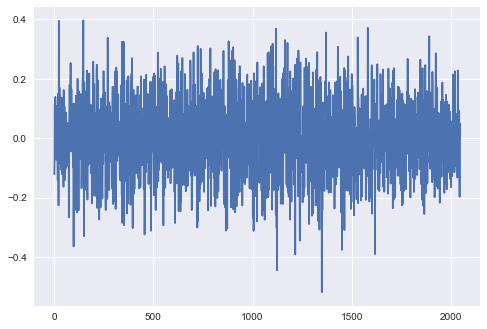

In [8]:
# Extract data from a single random serialized Example and plot it

from tfrecord_lite import tf_record_iterator
it = tf_record_iterator('C:\\Users\\solda\\Documents\\code\\ML\\mycnn_gw\\new\\trvaldata\\train_0.tfrecord')
parsed = [next(it) for _ in range(192)] # 1/5th of total data is saved as evaluation dataset -> only 4/5th of total data here

isig = np.random.randint(0,192, size=1)[0]
print(isig)
plt.plot(parsed[isig]['image'])
print(parsed[isig]['label'])
print(parsed[isig])

# To check that each file contains equally the 2 classes
count0=0
count1=0
for isig in range(192):
    if parsed[isig]['label']==0:
        count0+=1
    else:
        count1+=1
count0,count1

47
[1]
{'label': array([1], dtype=int64), 'image': array([-0.06665699,  0.0218042 ,  0.19212815, ..., -0.02464357,
        0.09443397,  0.1449057 ], dtype=float32)}


(24, 24)

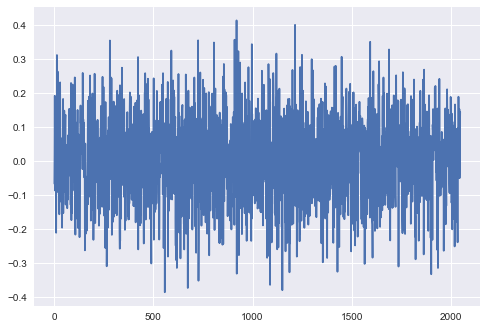

In [9]:
# Extract data from a single random serialized Example and plot it

from tfrecord_lite import tf_record_iterator
it = tf_record_iterator('C:\\Users\\solda\\Documents\\code\\ML\\mycnn_gw\\new\\trvaldata\\eval_0.tfrecord')
parsed = [next(it) for _ in range(48)] # 1/5th of total data is saved as evaluation dataset -> only 4/5th of total data here

isig = np.random.randint(0,48, size=1)[0]
print(isig)
plt.plot(parsed[isig]['image'])
print(parsed[isig]['label'])
print(parsed[isig])

# To check that each file contains equally the 2 classes
count0=0
count1=0
for isig in range(48):
    if parsed[isig]['label']==0:
        count0+=1
    else:
        count1+=1
count0,count1

Now the optimisation procedure can start. The objective sets the quantitiy that should be maximised: in this case we use the accuracy of the model on the validation set. Note that Kears automatically converts the accuracy to the binary accuracy in the case of a binary crossentropy loss function. We use the callback to tell Keras to stop training the current model if the validation loss does not improve significantly during 5 subsequent epochs.

In [10]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [11]:
tuner.search(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=[stop_early])

Trial 30 Complete [00h 00m 05s]
val_loss: 0.36276543140411377

Best val_loss So Far: 0.2342907041311264
Total elapsed time: 00h 02m 01s
INFO:tensorflow:Oracle triggered exit


Let's now print the hyperparameters of the best model the tuner has found, and load them into our model.

In [12]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best number of filters: {} for layer 1, {} for layer 2'.format(best_hps.get('filters_1'),best_hps.get('filters_2')))
print('Best size of kernels: {} for layer 1, {} for layer 2'.format(best_hps.get('kernelsize_1'),best_hps.get('kernelsize_2')))
print('Best maxpooling factor: {} for layer 1, {} for layer 2'.format(best_hps.get('maxpooling_1'),best_hps.get('maxpooling_2')))

Best number of filters: 20 for layer 1, 12 for layer 2
Best size of kernels: 16 for layer 1, 2 for layer 2
Best maxpooling factor: 3 for layer 1, 3 for layer 2


In [13]:
model_m = tuner.hypermodel.build(best_hps)
model_m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2033, 20)          340       
_________________________________________________________________
dropout (Dropout)            (None, 2033, 20)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 677, 20)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 676, 12)           492       
_________________________________________________________________
dropout_1 (Dropout)          (None, 676, 12)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 225, 12)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2700)              0

Using the optimised model, we now fully train it on the whole dataset. We also tell Keras to save logs, in case we want to check them using Tensorboard.

Next, we plot the accuracy and loss to check the performance and the presence overfitting.

In [14]:
# Train the CNN

callbacks_list = [
                       keras.callbacks.ModelCheckpoint(
                           filepath='best_model.{epoch:02d}-{binary_accuracy:.2f}.h5',
                           monitor='val_accuracy', save_best_only=True),
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
                            keras.callbacks.TensorBoard(
                            log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True,
                            update_freq='epoch'),
                    ]

epochs = 10
#STEPS_PER_EPOCH = int((n_bbh+n_noise)*n_chunks/batch_size)

print("\n Training CNN model... \n")
#print("\n Steps per epoch: ~",STEPS_PER_EPOCH,".\n")
start_time = time.time()

history = model_m.fit(train_dataset,
                      epochs=epochs,
#                       steps_per_epoch=STEPS_PER_EPOCH)
                      validation_data=validation_dataset,  
                      callbacks=callbacks_list,
                      verbose=1,
                      shuffle=True,
                      use_multiprocessing=True)

end_time = time.time()

print("\n Training time: ",end_time-start_time,"s")

print("\n CNN model trained... \n")


 Training CNN model... 

Epoch 1/10
18/18 [==============================] - 3s 74ms/step - loss: 0.7399 - binary_accuracy: 0.4980 - binary_crossentropy: 0.7399 - val_loss: 0.6896 - val_binary_accuracy: 0.6580 - val_binary_crossentropy: 0.6896
Epoch 2/10
18/18 [==============================] - 0s 18ms/step - loss: 0.6980 - binary_accuracy: 0.5530 - binary_crossentropy: 0.6980 - val_loss: 0.6878 - val_binary_accuracy: 0.7674 - val_binary_crossentropy: 0.6878
Epoch 3/10
18/18 [==============================] - 0s 18ms/step - loss: 0.6594 - binary_accuracy: 0.6073 - binary_crossentropy: 0.6594 - val_loss: 0.6850 - val_binary_accuracy: 0.9045 - val_binary_crossentropy: 0.6850
Epoch 4/10
18/18 [==============================] - 0s 19ms/step - loss: 0.6200 - binary_accuracy: 0.6789 - binary_crossentropy: 0.6200 - val_loss: 0.6728 - val_binary_accuracy: 0.9497 - val_binary_crossentropy: 0.6728
Epoch 5/10
18/18 [==============================] - 0s 18ms/step - loss: 0.5689 - binary_accuracy:

Only ~8 seconds are needed to train a network which has a ~100% high accuracy on both the training and the validation sets. However, the loss is a bit higher on the validation set than on the training set, thus indicating a bit of overfitting. For this reason, we stop the training at just 10 epochs.


 --- Learning curve of training --- 



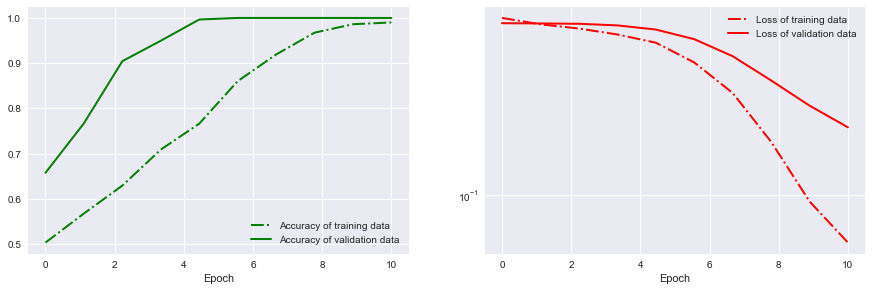

In [15]:
print("\n --- Learning curve of training --- \n")

# Plot accuracy and loss

x_plot=np.linspace(0,len(history.history['binary_accuracy']),len(history.history['binary_accuracy']))

fig = plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(x_plot,history.history['binary_accuracy'],color='green',linewidth=2,linestyle='-.',label='Accuracy of training data')
plt.plot(x_plot,history.history['val_binary_accuracy'],color='green',linewidth=2,linestyle='-',label='Accuracy of validation data')
plt.legend()
plt.xlabel('Epoch')

plt.subplot(222)
plt.plot(x_plot,history.history['loss'],color='red',linewidth=2,linestyle='-.',label='Loss of training data')
plt.plot(x_plot,history.history['val_loss'],color='red',linewidth=2,linestyle='-',label='Loss of validation data')
plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')

fig.savefig('loss_accuracy.png', bbox_inches='tight', pad_inches=0.5, format='png')

Let's save the weights of the model into a file, so that the can be reloaded easlisy when needed, whithout retraining the network.

In [16]:
# Save model to JSON file

model_json = model_m.to_json()
with open(os.path.join(thispath,"my_cnn_v11.json"), "w") as json_file:
    json_file.write(model_json)

# Save weights to HDF5 file

model_m.save_weights(os.path.join(thispath,"my_cnn_v11.h5"))

print("\n Saved trained model to disk \n")


 Saved trained model to disk 



# Test

We now load the saved weights of the model we trained. Then, we load the test data and perform the evaluation of our model on the test set.

In [17]:
# Load JSON and create model

json_file = open(os.path.join(thispath,'my_cnn_v11.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model

loaded_model.load_weights(os.path.join(thispath,"my_cnn_v11.h5"))
loaded_model.summary()
print("Loaded trained model from disk")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2033, 20)          340       
_________________________________________________________________
dropout (Dropout)            (None, 2033, 20)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 677, 20)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 676, 12)           492       
_________________________________________________________________
dropout_1 (Dropout)          (None, 676, 12)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 225, 12)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2700)              0

In [18]:
pathtest = os.path.join(datapath,'testdata')

f = np.fromfile(os.path.join(pathtest,'config.txt'),count=-1,sep=' ')

n_timesteps = int(f[0])
n_tot = int(f[1])
n_bbh = int(f[2])
n_noise = int(f[3])
n_chunks = int(f[4])

print("\n Number of timesteps for each sample: ", n_timesteps,". \n")
print("\n Number of samples in each data file: ", n_bbh, 'signals + ', n_noise, 'noises. \n' )

test_files = os.listdir(pathtest)
testfiles = []     # path of the test data files
cleanfiles = []     # path of the test data files containing only clean strain
test_paths = []
clean_paths = []
test_numfiles = 0
clean_numfiles = 0

# Loops on each file/folder in the specified path
for filename in test_files: 
    # Check if the file's name begins with 'train' and ends with ".txt"
    if filename.startswith('test') and filename.endswith('.txt'): 
        testfiles.append(filename)
        test_numfiles=test_numfiles+1
    if filename.startswith('clean') and filename.endswith('.txt'): 
        cleanfiles.append(filename)
        clean_numfiles=clean_numfiles+1

# Saves the paths of the data files
for l in range(len(testfiles)):test_paths.append(os.path.join(pathtest,testfiles[l]))   
for l in range(len(cleanfiles)):clean_paths.append(os.path.join(pathtest,cleanfiles[l]))   

n_tot_test = n_bbh*len(test_paths)+n_noise*len(test_paths)
    
print("\n Number of test data files: ", len(test_paths),'. \n' )
print("\n Total number of samples: ", n_bbh*len(test_paths), 'signals + ', n_noise*len(test_paths), 'noises = ',n_tot_test ,'. \n' )


 Number of timesteps for each sample:  2048 . 


 Number of samples in each data file:  72 signals +  72 noises. 


 Number of test data files:  12 . 


 Total number of samples:  864 signals +  864 noises =  1728 . 



In [19]:
print("\n Loading test data from disk... \n")

i = 0

for path in test_paths:
    test_samples_new = np.fromfile(path,count=-1,sep=' ')
    test_samples_new = test_samples_new.reshape((n_bbh+n_noise,n_timesteps+3))
    if i == 0:
        test_samples = test_samples_new
    else:
        test_samples = np.vstack((test_samples,test_samples_new))
    i+=1

i = 0
for path in clean_paths:
    clean_samples_new = np.fromfile(path,count=-1,sep=' ')
    clean_samples_new = clean_samples_new.reshape((n_bbh,n_timesteps+2))
    if i == 0:
        clean_samples = clean_samples_new
    else:
        clean_samples = np.vstack((clean_samples,clean_samples_new))
    i+=1
    
x_test = np.delete(test_samples,-1, axis=1)
x_test = np.delete(x_test,-1, axis=1)
x_test = np.delete(x_test,-1, axis=1) # time series data

y_test = test_samples[:,-3] # labels (0 or 1)
    
x_test = np.asarray(x_test, dtype= np.float64).reshape(-1, n_timesteps, 1)
y_test = np.asarray(y_test)

print("\n Test data loaded --- \n")
print("\n --- Test set shape --- \n")
print("x:", x_test.shape)
print("y:", y_test.shape)


 Loading test data from disk... 


 Test data loaded --- 


 --- Test set shape --- 

x: (1728, 2048, 1)
y: (1728,)


In [20]:
# Check against test data

print("\n Checking against test data... \n")

loaded_model.compile(loss='binary_crossentropy',
                    optimizer='Adam', 
                    metrics=['binary_accuracy',tf.keras.metrics.BinaryCrossentropy()])

score = loaded_model.evaluate(x_test, y_test)

print("\nAccuracy on test data: %0.4f" % score[1])
print("\nLoss on test data: %0.4f" % score[0])


 Checking against test data... 

54/54 [==============================] - 0s 2ms/step - loss: 0.2208 - binary_accuracy: 1.0000 - binary_crossentropy: 0.2208

Accuracy on test data: 1.0000

Loss on test data: 0.2192


We see that the accuracy reaches ~100%, like on the training and validation sets. However, accuracy in general doesn't tell us the whole story: when the two classes (e.g. there is a GW vs there is not a GW) are imbalanced, the accuracy can be heavily biased and might not mean that the model actually performs well. For this reason, we want to check separately the number of true positives, true negatives, false positives and false negatives. Since the absence of a signal is indicated by a value of SNR equal to exactly 0, while the presence of a signal means that SNR>0 strictly, we can order all the test samples by the SNR and check whether the models assigned probabilities lower than 0.5 to all samples with SNR=0, and probabilities higher than 0.5 to all samples with SNR>0.

In [21]:
# Order the test set by SNR
# WARNING: this may take some time!

ind = test_samples[:,-1].argsort()
ord_samples = test_samples[ind]

snr = []
prob = []

for i in range(len(ord_samples)):
    xsig = np.asarray(ord_samples[i][:-3], dtype= np.float64).reshape(-1, n_timesteps, 1)
    snr.append(ord_samples[i][-1])
    prob.append((loaded_model.predict(xsig))[0][0])


 Number of true negatives:  864

 Number of true positives:  864

 Number of false negatives:  0

 Number of false positives:  0


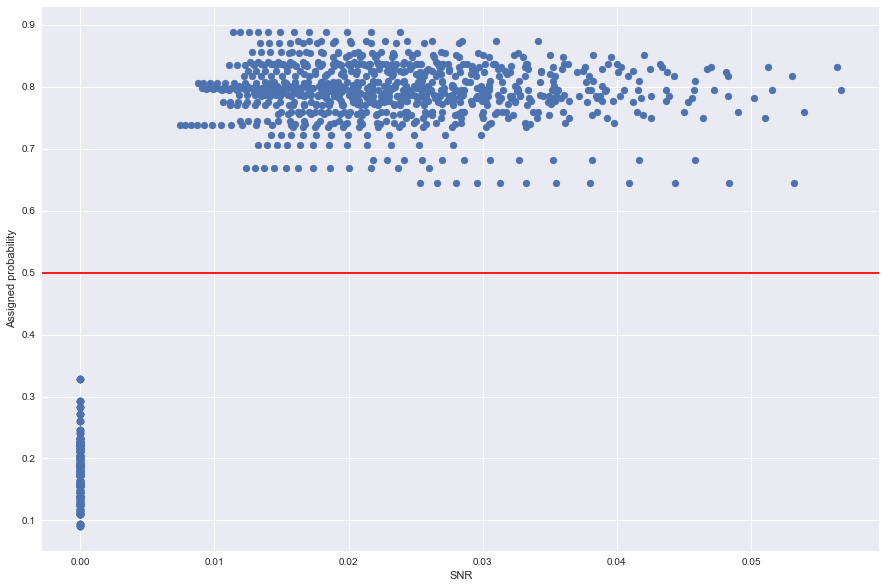

In [22]:
# Plot predictions vs SNR

prob = np.asarray(prob)
snr = np.asarray(snr)

TN = np.sum(np.logical_and(np.less(prob,[0.5]), np.equal(snr,[0])))
TP = np.sum(np.logical_and(np.greater(prob,[0.5]), np.not_equal(snr,[0])))
FN = np.sum(np.logical_and(np.less(prob,[0.5]), np.not_equal(snr,[0])))
FP = np.sum(np.logical_and(np.greater(prob,[0.5]), np.equal(snr,[0])))

print("\n Number of true negatives: ", TN)
print("\n Number of true positives: ", TP)
print("\n Number of false negatives: ", FN)
print("\n Number of false positives: ", FP)

fig = plt.figure(figsize=(15,10))
plt.scatter(snr,prob)
plt.axhline(0.5,color='red')
plt.xlabel('SNR')
plt.ylabel('Assigned probability')
fig.savefig('snr.png', bbox_inches='tight', pad_inches=0.5, format='png')

As we can see, all pure noise signals are classified as having label 0, just like all signals containing a GW event are classified as having label 1. However, we can see that the confidence of the network in making these decisions is sometimes not very high. Let's plot these results as a confusion matrix.

Text(52.0, 0.5, 'Predicted')

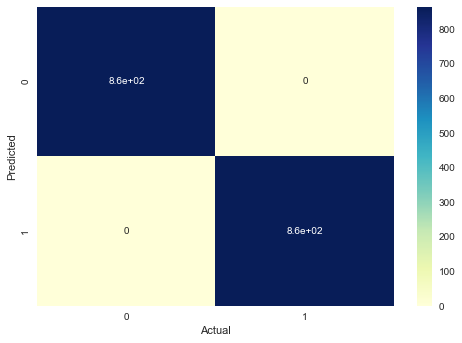

In [23]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

y_pred = (loaded_model.predict(x_test)>0.5)+0 # predict and get class (0 if pred < 0.5 else 1)
confusion_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(confusion_matrix)
cm = sns.heatmap(df_cm, annot=True, cmap='YlGnBu')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [ ]:
# Check against test data from a specific checkpoint

print("\n Checking against test data... \n")

checkpoint_path = 'best_model.01-0.83.h5'
loaded_model.load_weights(checkpoint_path)

score = loaded_model.evaluate(test_dataset, verbose=1, batch_size=128)

print("\nAccuracy on test data: %0.4f" % score[1])
print("\nLoss on test data: %0.4f" % score[0])

While we know the overall performance of the model on the test set, we might be curious to test it on individual samples, to have an idea of what the network was able to discover. Moreover, we might be curious to see the actual probability that the model assigns to a particular sample, and not only whether it is higher or lower than 0.5.

901
0.8882249
SNR:  0.011921609937424539

 Predicted label of the input signal (1=signal; 0=noise): 0.8882249 => 1

 Actual label of the input signal (1=signal; 0=noise): 1.0


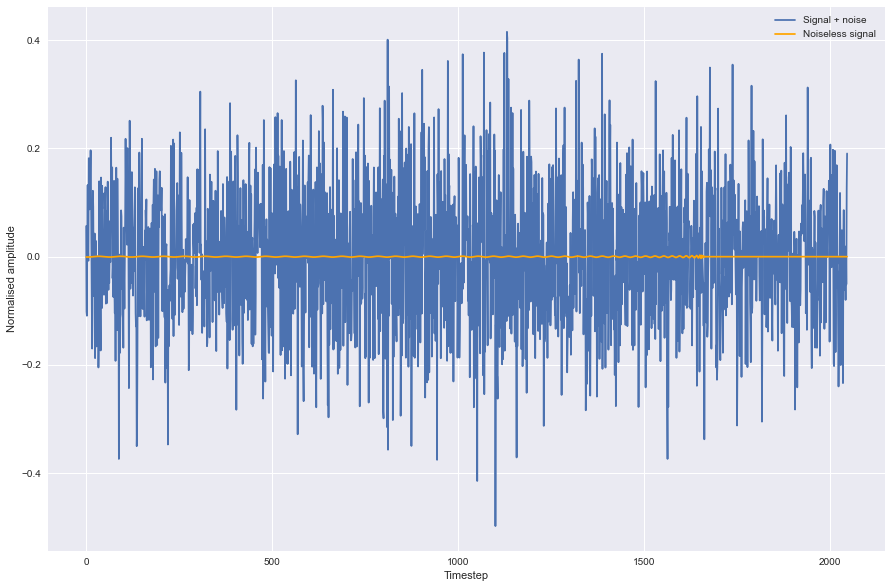

In [78]:
# To test a single signal

isig = np.random.randint(0,n_tot_test, size=1)[0]
print(isig)

id_sample = ord_samples[isig][-2]


xsig = np.asarray(ord_samples[isig][:-3], dtype= np.float64).reshape(-1, n_timesteps, 1)
print(loaded_model.predict(xsig)[0][0])
fig = plt.figure(figsize=(15,10))

print('SNR: ',ord_samples[isig][-1])
plt.plot(xsig[0],label='Signal + noise')
plt.xlabel('Timestep')
plt.ylabel('Normalised amplitude')

if ord_samples[isig][-3]==1.0: # if signal contains an event
    for i in range(len(clean_samples)):
        if clean_samples[i][-1]==id_sample:
            plt.plot(clean_samples[i][:-2],color='orange',label='Noiseless signal')
            #print(max(clean_samples[i][:-2]))
            #print(max(xsig[0]))
            break
plt.legend()
print("\n Predicted label of the input signal (1=signal; 0=noise):",loaded_model.predict(xsig)[0][0],"=>",(loaded_model.predict(xsig)[0][0] > 0.5).astype("int32"))
print("\n Actual label of the input signal (1=signal; 0=noise):",ord_samples[isig][-3])

fig.savefig('example_test.png', bbox_inches='tight', pad_inches=0.5, format='png')

Overall, the network we trained is very simple and very accurate. Of course, this comes with some caveats:

* As you can see by plotting as many samples as you want, they all reach the "merger", i.e. the point of contact between the two black holes, corresponding to the timestep where the signal drops to exactly zero, at the same time. This could somehow be recognised by the network, which thus would not generalise well to real signals, where the time of merger is not fixed. To understand this, we would need to generate samples with e.g. a random merger time inside a certain time window to understand whether the variation (or even the actual value) of the merger time influences the decision of the network.

* While the noise we used is randomly generated from a particular function that simulates the noise of the LIGO detectors, it would be interesting whether using an even more random noise (e.g. the noise of different detectors) the performance of the network is different.

* GW detectors also happen to have "glitches", that is sudden spikes of power registered by the detector for reasons which are not related to GWs: it would be interesting to look whether adding glitches to the samples changes the performance of the network, as they might be misclassified as GW signals.

* It would be worth to try more specialised networks such a recurrent neural networks or long short term memory networks, especially as incorporating the previous points might probably have the effect of reducing the accuracy of the network.